In [150]:
from numba import jit
import numpy as np
from scipy import stats
from scipy.optimize import root
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [24]:
def NC_methods(g, a, b, N, method='midpoint'):
    intervals = np.linspace(a, b, N)
    if method == 'midpoint':
        estimation = sum([(intervals[i + 1] - intervals[i]) * g((intervals[i] + intervals[i + 1]) / 2) for i in range(N - 1)])
        return estimation
    if method == 'trapezoid':
        estimation = sum([((intervals[i + 1] - intervals[i]) / 2) * (g(intervals[i]) + g(intervals[i + 1])) for i in range(N-1)])
        return estimation
    if method == 'Simpsons':
        estimation = sum([((intervals[i + 1] - intervals[i]) / 6) * (g(intervals[i]) + 4 * g((intervals[i] + intervals[i + 1]) / 2) + g(intervals[i + 1])) for i in range(N-1)])
        return estimation
    
g = lambda x: 0.1*x**4 - 1.5*x**3 + 0.53*x**2 + 2*x + 1

true_val = 4373 + (1/3)
        
print('midpoint error: {}'.format(abs(true_val - NC_methods(g, -10, 10, 1000))))
print('trapezoid error: {}'.format(abs(true_val - NC_methods(g, -10, 10, 1000, method='trapezoid'))))
print('Simpsons error: {}'.format(abs(true_val - NC_methods(g, -10, 10, 1000, method='Simpsons'))))

midpoint error: 0.013714071739741485
trapezoid error: 0.027428151536696532
Simpsons error: 2.6702764444053173e-09


nodes: [-4.  -3.2 -2.4 -1.6 -0.8  0.   0.8  1.6  2.4  3.2  4. ]
weights: [  3.16712418e-05   2.39602174e-03   2.01950016e-02   9.23195383e-02
   2.29508588e-01   3.10843483e-01   2.29508588e-01   9.23195383e-02
   2.01950016e-02   2.39602174e-03   3.16712418e-05]


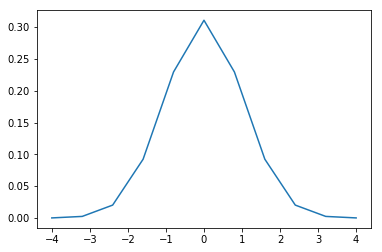

In [28]:
def N_distribution(mu, sigma, N, sd_num):
    lb = mu - sd_num * sigma
    ub = mu + sd_num * sigma
    nodes = np.linspace(lb, ub, N)
    weights = np.empty(N)
    for i in range(N):
        if i == 0:
            weights[i] = stats.norm.cdf(nodes[i], loc=mu, scale=sigma)
        elif i == N - 1:
            weights[i] = 1 - stats.norm.cdf(nodes[i], loc=mu, scale=sigma)
        else:
            weights[i] = NC_methods(lambda x: stats.norm.pdf(x, loc=mu, scale=sigma), (nodes[i - 1] + nodes[i]) / 2, (nodes[i] + nodes[i + 1]) / 2, 1000, method='Simpsons')
    return nodes, weights

nodes, weights = N_distribution(0, 1, 11, 4)
print('nodes: {}'.format(nodes))
print('weights: {}'.format(weights))
plt.plot(nodes, weights)
plt.show()


nodes: [  1.83156389e-02   4.07622040e-02   9.07179533e-02   2.01896518e-01
   4.49328964e-01   1.00000000e+00   2.22554093e+00   4.95303242e+00
   1.10231764e+01   2.45325302e+01   5.45981500e+01]
weights: [  3.16712418e-05   2.39602174e-03   2.01950016e-02   9.23195383e-02
   2.29508588e-01   3.10843483e-01   2.29508588e-01   9.23195383e-02
   2.01950016e-02   2.39602174e-03   3.16712418e-05]


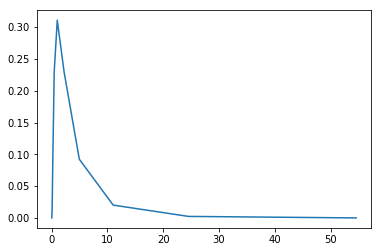

In [32]:
def LN_distribution(mu, sigma, N, sd_num):
    #Note that mu and sigma are NOT the mean and SD of the LN distribution, 
    #but rather those of the corresponding normal distribution.
    nodes, weights = N_distribution(mu, sigma, N, sd_num)
    log_nodes = np.e ** nodes
    return log_nodes, weights

nodes, weights = LN_distribution(0, 1, 11, 4)
print('nodes: {}'.format(nodes))
print('weights: {}'.format(weights))
plt.plot(nodes, weights)
plt.show()

In [37]:
def get_LN_mu(mu, sigma, N, sd_num):
    #Note that mu and sigma are NOT the mean and SD of the LN distribution, 
    #but rather those of the corresponding normal distribution.
    nodes, weights = LN_distribution(mu, sigma, N, sd_num)
    #Use trapezoid estimate
    return nodes@weights

#I would not recommend running this, it takes forever.
print(get_LN_mu(10.5, 0.8, 1000, 5))
print(np.e ** (10.5 + (0.8 ** 2) / 2))

50011.1066523
50011.08700852173


In [72]:
g = lambda x: 0.1*x**4 - 1.5*x**3 + 0.53*x**2 + 2*x + 1

def error_g(params):
    omega_1, omega_2, omega_3, x_1, x_2, x_3 = params
    error1 = 20 - omega_1 - omega_2 - omega_3
    error2 = -omega_1*x_1 - omega_2*x_2 - omega_3*x_3
    error3 = (2000 / 3) - omega_1*x_1**2 - omega_2*x_2**2 - omega_3*x_3**2
    error4 = -omega_1*x_1**3 - omega_2*x_2**3 - omega_3*x_3**3
    error5 = 40000 - omega_1*x_1**4 - omega_2*x_2**4 - omega_3*x_3**4
    error6 = -omega_1*x_1**5 - omega_2*x_2**5 - omega_3*x_3**5
    return np.array([error1, error2, error3, error4, error5, error6])


def approx_g(g, params):
    omega_1, omega_2, omega_3, x_1, x_2, x_3 = root(error_g, params, tol=1e-20).x
    return omega_1*g(x_1) + omega_2*g(x_2) + omega_3*g(x_3)

#Note that this breaks for a bad intial guess...
#However, the accuracy is very good.
print('Gaussian quadrature approximation: {}'.format(approx_g(g, np.array([2, 1, 1, 1, 1, 1]))))

print('scipy.integrate.quad approximation: {}'.format(quad(g, -10, 10)[0]))

Gaussian quadrature approximation: 4373.333333333333
scipy.integrate.quad approximation: 4373.333333333334


In [246]:
def MC_integr(g, Omega, N):
    assert Omega.shape[1] == 2, 'Please enter a two dimensional array with interval entries.'
    V = np.product(Omega[:, 1] - Omega[:, 0])
    integral = V * sum(map(g, zip(*map(lambda x: np.random.uniform(x[0], x[1], N), Omega)))) / N
    return integral

@jit
def g(x):
    if x[0] ** 2 + x[1] ** 2 <= 1:
        return 1
    else:
        return 0

#4 decimal places for N around 100,000,000
MC_integr(g, np.array([[-1, 1], [-1, 1]]), 100000000)

3.1415040799999998

In [283]:
def prime(i, primes):
    for prime in primes:
        if not (i == prime or i % prime):
            return False
    primes.add(i)
    return i

def get_primes(n):
    primes = set([2])
    i, p = 2, 0
    while True:
        if prime(i, primes):
            p += 1
            if p == n:
                return primes
        i += 1

def EQ_element(n, d, name='Weyl'):
    element = []
    if name == 'Weyl':
        primes = get_primes(d)
        for prime in primes:
            element.append(n * (prime ** 0.5) % 1)
    elif name == 'Haber':
        primes = get_primes(d)
        for prime in primes:
            element.append((n * (n + 1) / 2) * (prime ** 0.5) % 1)
    elif name == 'Niederreiter':
        for i in range(d):
            element.append(n * (2 ** ((i + 1) / (n + 1))) % 1)
    elif name == 'Baker':
        for i in range(d):
            element.append(n * (np.e ** (i + 1)) % 1)
    else:
        raise ValueError('Please enter a valid name.')
    return element

In [297]:
def qMC_integr(g, Omega, N):
    assert Omega.shape[1] == 2, 'Please enter a two dimensional array with interval entries.'
    n = Omega.shape[0]
    V = np.product(Omega[:, 1] - Omega[:, 0])
    EQ_sequence = [[EQ_element(i + 1, n)[j] * (Omega[j, 1] - Omega[j, 0]) + Omega[j, 0]  for j in range(n)] for i in range(N)]
    integral = V * sum(map(g, EQ_sequence)) / N
    return integral

@jit
def g(x):
    if x[0] ** 2 + x[1] ** 2 <= 1:
        return 1
    else:
        return 0

#4 decimal places for N around 10,000,000
qMC_integr(g, np.array([[-1, 1], [-1, 1]]), 10000000)

3.1415576000000001